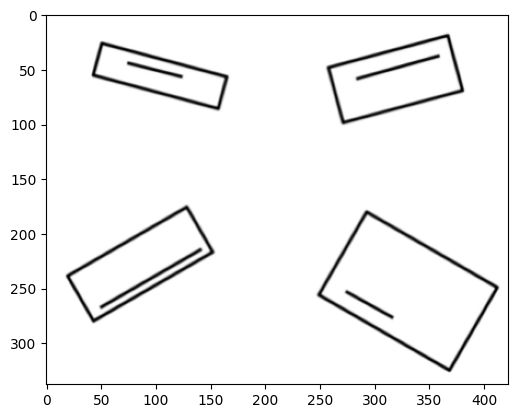

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

image = cv2.imread('../rects.png')

plt.imshow(image)
plt.show()

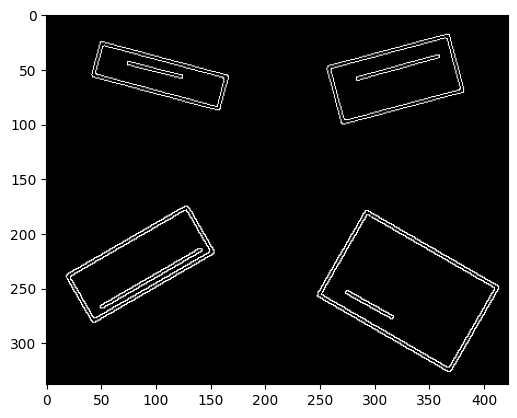

In [2]:
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
edges = cv2.Canny(gray, 50, 150)

plt.imshow(cv2.cvtColor(edges, cv2.COLOR_GRAY2RGB))
plt.show()

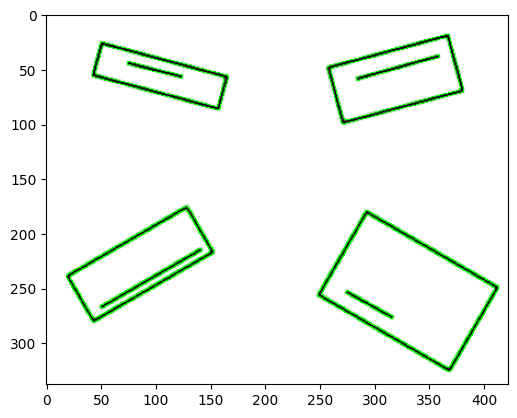

In [3]:
contours, hierarchy = cv2.findContours(edges, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)

contour_image = image.copy()

cv2.drawContours(contour_image, contours, -1, (0, 255, 0), 1)

plt.imshow(cv2.cvtColor(contour_image, cv2.COLOR_BGR2RGB))
plt.show()

In [4]:
def cart2pol(x, y):
    theta = np.arctan2(y, x)
    rho = np.hypot(x, y)
    return theta, rho


def pol2cart(theta, rho):
    x = rho * np.cos(theta)
    y = rho * np.sin(theta)
    return x, y


def rotate_contour(cnt, angle):
    M = cv2.moments(cnt)
    cx = int(M['m10']/M['m00'])
    cy = int(M['m01']/M['m00'])

    cnt_norm = cnt - [cx, cy]
    
    coordinates = cnt_norm[:, 0, :]
    xs, ys = coordinates[:, 0], coordinates[:, 1]
    thetas, rhos = cart2pol(xs, ys)
    
    thetas = np.rad2deg(thetas)
    thetas = (thetas + angle) % 360
    thetas = np.deg2rad(thetas)
    
    xs, ys = pol2cart(thetas, rhos)
    
    cnt_norm[:, 0, 0] = xs
    cnt_norm[:, 0, 1] = ys

    cnt_rotated = cnt_norm + [cx, cy]
    cnt_rotated = cnt_rotated.astype(np.int32)

    return cnt_rotated

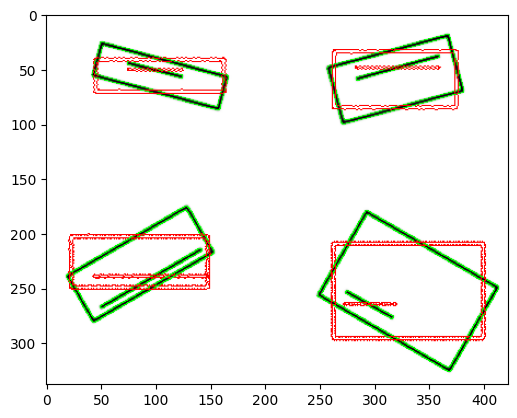

In [5]:
for contour in contours:
    rect = cv2.minAreaRect(contour)
    box = cv2.boxPoints(rect)

    side_lengths = np.linalg.norm(np.diff(np.vstack((box, box[0]))), axis=1)
    longest_side_index = np.argmax(side_lengths)

    angle = -np.degrees(np.arctan2(box[longest_side_index][1] - box[longest_side_index - 1][1],
                                   box[longest_side_index][0] - box[longest_side_index - 1][0]))

    rotated_contour = rotate_contour(contour, angle)

    cv2.drawContours(contour_image, [contour], 0, (0, 255, 0), 1)

    cv2.drawContours(contour_image, [rotated_contour], 0, (0, 0, 255), 1)

plt.imshow(cv2.cvtColor(contour_image, cv2.COLOR_BGR2RGB))
plt.show()

In [6]:
non_target_mask = np.all(contour_image != (255, 0, 0), axis=-1)

contour_image[non_target_mask] = (255, 255, 255)

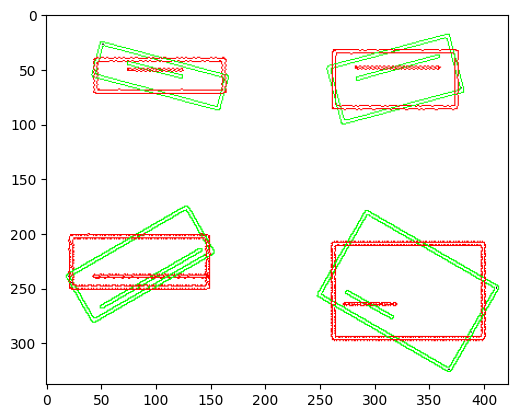

In [7]:

plt.imshow(cv2.cvtColor(contour_image, cv2.COLOR_BGR2RGB))
plt.show()

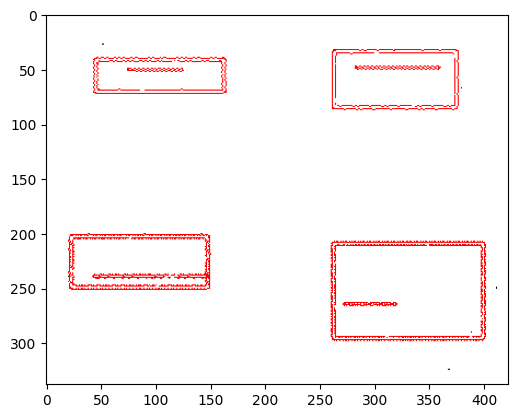

In [8]:
target_mask = np.all(contour_image == (0, 255, 0), axis=-1)

contour_image[target_mask] = (255, 255, 255)

plt.imshow(cv2.cvtColor(contour_image, cv2.COLOR_BGR2RGB))
plt.show()

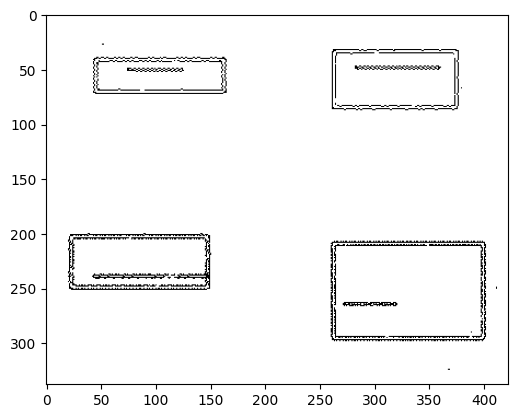

In [9]:
target_mask = np.all(contour_image == (0, 0, 255), axis=-1)

contour_image[target_mask] = (0, 0, 0)

plt.imshow(cv2.cvtColor(contour_image, cv2.COLOR_BGR2RGB))
plt.show()

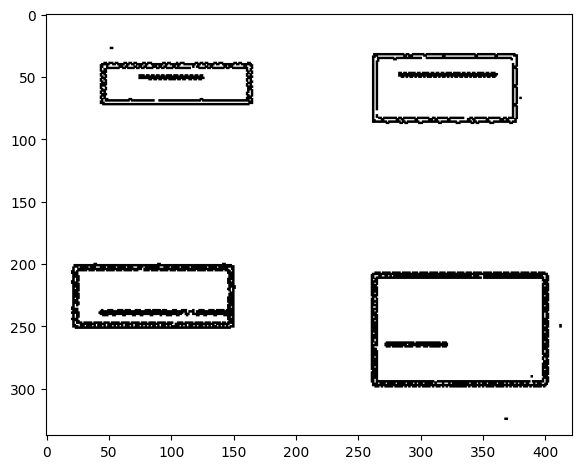

In [10]:
original_image = contour_image

_, binary_image = cv2.threshold(original_image, 127, 255, cv2.THRESH_BINARY_INV)

kernel_size = 2
kernel = np.ones((kernel_size, kernel_size), np.uint8)

connected_lines_image = cv2.dilate(binary_image, kernel, iterations=1)

final_result = cv2.bitwise_not(connected_lines_image)

plt.imshow(final_result, cmap='gray')

plt.tight_layout()
plt.show()